# word2vec + XGBoost Classifier (BPE: 2000개)
- word2vec: opcode BPE token을 임베딩
- XGBoost Classifier: 임베딩값을 분류
- accuracy: 0.9940119760479041
- dataset1(DikeDataset): https://github.com/iosifache/DikeDataset
- dataset2(GnuWin Packages): http://gnuwin32.sourceforge.net/packages.html
- BPE Token을 만드는 알고리즘은 utils 디렉토리 내부의 BPE Token generator.ipynb를 확인하시면 됩니다.

# 필요 pacakge 설치

In [1]:
!pip install pefile
!pip install capstone

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 228 kB/s 
  Created wheel for pefile: filename=pefile-2021.9.3-py3-none-any.whl size=68844 sha256=8532c03e88214be8d0169c410f4ed075a3f99280d7a0e8233aa116ea47e5b51a
  Stored in directory: /root/.cache/pip/wheels/50/be/9b/d19a6151b9c6e303f823faedf03193d7e90dac4009a0bdafeb
Successfully built pefile
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 3.6 MB/s 


# utils.py 파일, sample 파일이 있는 폴더로 위치 변경

In [11]:
%cd /content/drive/MyDrive/Capstone Design Project + 한이음 과정/code/휴지통/test

/content/drive/MyDrive/Capstone Design Project + 한이음 과정/code/휴지통/test


# 필요 package Import

In [12]:
from utils import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import time

In [13]:
import tqdm
from tqdm import tqdm_notebook
tqdm_notebook()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


0it [00:00, ?it/s]

# Data load

# word2vec model 학습을 위한 BPE sequence list 생성
- 미리 제작된 BPE sequence list를 활용
- 해당 형태로 Input을 만들기를 희망하면 utils.py 모듈 내부의 함수 ExtractPefileOpcodes를 통해 sequence 데이터를 얻은 뒤, Tokenizer함수를 통해 token화 해서 사용하면 됩니다.

In [5]:
with open('/content/drive/MyDrive/Capstone Design Project + 한이음 과정/code/files/BPE Database/2000opcodeList_checkpoint.p', 'rb') as file:
    opcodeSequenceList = pickle.load(file)

print(opcodeSequenceList[0])

[['push', 'mov', 'sub'], ['push', 'push', 'push'], ['mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'call'], ['mov', 'cmp', 'jbe'], ['mov', 'mov', 'mov', 'mov', 'mov', 'cmp'], ['jmp'], ['push', 'call'], ['mov', 'push', 'mov', 'push', 'call', 'add'], ['mov', 'adc'], ['xchg', 'cmp'], ['jo'], ['inc', 'add'], ['push', 'push', 'call'], ['xor', 'pop', 'pop', 'pop', 'mov'], ['pop', 'ret', 'push', 'mov', 'sub'], ['push', 'push', 'push'], ['mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov'], ['mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov'], ['mov', 'mov', 'cmp', 'je'], ['mov', 'mov', 'mov'], ['push', 'mov'], ['shl'], ['mov', 'pop'], ['mov', 'jmp'], ['mov', 'mov', 'mov'], ['push', 'mov', 'sub'], ['mov', 'mov', 'mov', 'mov'], ['pop'], ['mov', 'mov', 'add'], ['mov', 'mov', 'mov', 'sub'], ['mov', 'push'], ['pop', 'mov', 'mov'], ['add', 'mov'], ['push', 'lea'], ['push', 'mov', 'mov'], ['lea', 'push', 'call', 'add'], ['push', 'lea', 'push', 'lea'], ['push', 'c

In [6]:
BPE_List = []

for ops in tqdm.notebook.tqdm(opcodeSequenceList):
    tempL = []
    for op in ops:
        tempS = ''
        for o in op:
            tempS = tempS + o
        tempL.append(tempS)
    BPE_List.append(tempL)

  0%|          | 0/10854 [00:00<?, ?it/s]

In [7]:
print(BPE_List[0])

['pushmovsub', 'pushpushpush', 'movmovmovmovmovmovmovcall', 'movcmpjbe', 'movmovmovmovmovcmp', 'jmp', 'pushcall', 'movpushmovpushcalladd', 'movadc', 'xchgcmp', 'jo', 'incadd', 'pushpushcall', 'xorpoppoppopmov', 'popretpushmovsub', 'pushpushpush', 'movmovmovmovmovmovmovmov', 'movmovmovmovmovmovmovmovmovmovmovmov', 'movmovcmpje', 'movmovmov', 'pushmov', 'shl', 'movpop', 'movjmp', 'movmovmov', 'pushmovsub', 'movmovmovmov', 'pop', 'movmovadd', 'movmovmovsub', 'movpush', 'popmovmov', 'addmov', 'pushlea', 'pushmovmov', 'leapushcalladd', 'pushleapushlea', 'pushcalladd', 'movmovmovadd', 'movmovaddmov', 'pushlea', 'pushmovmov', 'leapushcalladd', 'movaddmovmovadd', 'movmovmovmovmovmovmovmov', 'movmovmovadd', 'movmovmov', 'imul', 'movmovpushmovadd', 'pushmovpushcalladd', 'movadd', 'movmovmovmovmovadd', 'movmovmovsub', 'movmovcmp', 'movjmpmovadd', 'movmovsub', 'movmovadd', 'movmovcmpjb', 'call', 'pushpushpushpushpushcall', 'pushpopmov', 'pushmovpushcall', 'xorpoppoppopmov', 'popretpushmovsub', 'mo

# Vocab Load

In [42]:
with open('2000vocab.p', 'rb') as file:
    vocab = pickle.load(file)

filePath = 'opcodesList.txt'
with open(filePath, 'rb') as lf:
    opcodes = pickle.load(lf)

opcodes2 = []
for i in range(len(opcodes)):
    opcodes2.append([opcodes[i]])

vocab = vocab + opcodes2

print(vocab[:20])

[['add', 'add'], ['mov', 'mov'], ['add', 'add', 'add', 'add'], ['push', 'push'], ['add', 'add', 'add', 'add', 'add', 'add', 'add', 'add'], ['push', 'call'], ['push', 'mov'], ['dec', 'mov'], ['mov', 'mov', 'mov', 'mov'], ['pop', 'pop'], ['mov', 'cmp'], ['add', 'add', 'add', 'add', 'add', 'add', 'add', 'add', 'add', 'add', 'add', 'add', 'add', 'add', 'add', 'add'], ['test', 'je'], ['mov', 'mov', 'mov'], ['mov', 'jmp'], ['cmp', 'je'], ['mov', 'add'], ['nop', 'nop'], ['pop', 'ret'], ['push', 'push', 'call']]


# BPE Token word2vec 모델 학습 및 저장

 ## word2vec Model Train

In [ ]:
word2vecModel = Word2Vec(sentences=BPE_List, size=1000, window=5, min_count=5, workers=4, sg=0)

## Trained word2vec model save and load

In [14]:
modelPath = 'BPEw2v2000'
word2vecModel.wv.save_word2vec_format(modelPath)
word2vecModel = KeyedVectors.load_word2vec_format(modelPath)

## word2vec model test

In [15]:
model_result = word2vecModel.most_similar("addadd")
print(model_result)

[('addaddadd', 0.4414026737213135), ('addaddaddadd', 0.3697534203529358), ('decaddaddadd', 0.3347220718860626), ('pushaddaddaddadd', 0.3212829530239105), ('addaddaddaddadd', 0.3178083300590515), ('adcaddadd', 0.31767505407333374), ('pushaddadd', 0.2995673418045044), ('jnpaddadd', 0.2970563769340515), ('pushaddaddadd', 0.29624754190444946), ('xchgaddadd', 0.2945404648780823)]


# opcode Sequence Embedding

## word2vec 임베딩 값을 위한 함수
- word2vec 임베딩 값의 평균을 임베딩 값으로 사용

In [16]:
def get_sentence_mean_vector(morphs):
    vector = []
    for i in morphs:
        try:
            vector.append(word2vecModel.wv[i])
        except KeyError as e:
            pass
    try:
        return np.array(np.mean(vector, axis=0), dtype = np.float64)
    except IndexError as e:
        pass

## Embedding 값 생성

In [18]:
classList = [0 for i in BPE_List]
LenList = [len(bpe) for bpe in BPE_List]

# Malware 범위만큼 label 값을 1로 주는 작업
for i in range(8639):
    classList[i] = 1

wareDict = {
    'BPE_List' : BPE_List,
    'Len' : LenList,
    'class' : classList
}

wareDf = pd.DataFrame.from_dict(wareDict)

wareDf

,BPE_List,Len,class
0,"[pushmovsub, pushpushpush, movmovmovmovmovmovm...",1228,1
1,"[pushmovsub, pushpushpush, movmovmovmovmovmovm...",2117,1
2,"[addxchg, addaddaddadd, xchgxchg, addadd, movt...",2320,1
3,"[pushmovsub, pushpush, movmovmovmovmovmovmovmo...",3140,1
4,"[pushmov, subsub, movpushadd, pushpush, movcmp...",30901,1
...,...,...,...
10849,"[pushmovsub, movmovxormovmovxor, movcmpja, cmp...",6054,0
10850,"[pushmovsub, movmovxormovmovxor, movcmpja, cmp...",6277,0
10851,"[or, jaejb, addaddaddaddaddaddaddadd, cmpinc, ...",5025,0
10852,"[or, jaejb, addaddaddaddaddaddaddadd, cmpinc, ...",5025,0


In [19]:
# 토큰이 없는 질문 data 삭제
for i in range(len(wareDf['Len'])):
    if wareDf['Len'][i] == 0:
        wareDf.drop([i], inplace=True)

# 중간 부분들이 행이 작제되면 인덱스 값에도 빈 공간이 생겨서 다시 채워주어야 함
index_=range(len(wareDf['Len']))
wareDf['index']=index_
wareDf.set_index('index', append=True)
wareDf.set_index('index', inplace=True)

wareDf['wv'] = wareDf['BPE_List'].map(get_sentence_mean_vector)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


In [20]:
wareDf.head()

,BPE_List,Len,class,wv
index,,,,
0,"[pushmovsub, pushpushpush, movmovmovmovmovmovm...",1228,1,"[0.17834116518497467, -0.1151927262544632, -0...."
1,"[pushmovsub, pushpushpush, movmovmovmovmovmovm...",2117,1,"[0.1641138345003128, -0.09887412190437317, -0...."
2,"[addxchg, addaddaddadd, xchgxchg, addadd, movt...",2320,1,"[0.08159252256155014, 0.11712568998336792, 0.0..."
3,"[pushmovsub, pushpush, movmovmovmovmovmovmovmo...",3140,1,"[0.17558084428310394, -0.12156093865633011, 0...."
4,"[pushmov, subsub, movpushadd, pushpush, movcmp...",30901,1,"[-0.21640963852405548, 0.20480476319789886, 0...."


# 독립변수와 종속변수 나누기

In [21]:
Y = wareDf['class'].to_list()

Y = np.array(Y)

Y.shape

(10852,)

In [22]:
X = wareDf['wv'].to_list()

X = np.array(X)

X.shape

(10852, 1000)

In [23]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(8681, 1000)
(2171, 1000)
(8681,)
(2171,)


In [24]:
start = time.time() 

# svm_classifier = SVC()
# svm_classifier.fit(x_train,y_train)
clf = XGBClassifier(booster = 'gbtree', importance_type = 'gain')
clf.fit(x_train,y_train)

end = time.time()
process = round(end-start,2)
print("XGBoost Classifier has fitted, this process took {} seconds".format(process))

XGBoost Classifier has fitted, this process took 46.88 seconds


In [29]:
# predict2 = svm_classifier.predict(x_test)
predict2 = clf.predict(x_test)

print(f'accuracy: {clf.score(x_test,y_test)}')

accuracy: 0.9940119760479041


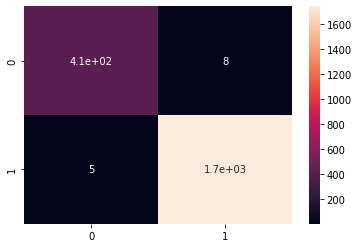

In [27]:
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(confusion_matrix(y_test, predict2), columns=[0, 1], index=[0, 1])
sns.heatmap(cm, annot=True)

# 모델 저장

In [28]:
# 파일명
filename = 'XGB_BPE2000_Word2vecClassifier.model'

# 모델 저장
pickle.dump(clf, open(filename, 'wb'))

# 모델 불러오기
clf = pickle.load(open(filename, 'rb'))

# Sample file Test
- Test를 위해 utils 폴더 내부의 utils.py 파일을 활용한다.

## MalwareDetectionFunction을 통한 Malware 탐지
- 양성 샘플 파일이 양성으로 결과가 나오는지 확인
- return 1: 악성코드, return 0: 양성코드

In [46]:
# 머신러닝 모델(XGBClassifier)을 바탕으로 해당 파일이 악성코드인지를 알려주는 함수
# return 1: 악성코드, return 0: 양성코드
def MalwareDetectionFunction(model, fileName):
    try:
        #parse exe file
        exe = pefile.PE(fileName)
        #call the function we created earlier
        sampleOpcodeList = ExtractPefileOpcodes(opcodes, exe)
    except:
        print('Error File')
    
    sampleTokenList = Tokenizer(vocab, sampleOpcodeList)
    inputData = get_sentence_mean_vector(sampleTokenList)
    inputData = [inputData]

    return model.predict(inputData)[0]

- 결과가 0으로 양성파일을 탐지한 것을 확인할 수 있다.

In [47]:
fileName = '3f3fe9ecad7f30fc80cdfb678d7ca27a30d0575a73818746e98be9170d3be348.exe'

MalwareDetectionFunction(clf, fileName)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


0